In [1]:
import numpy as np
from PIL import Image
import os, re, sys
import scipy.spatial.distance
from datetime import datetime
import matplotlib.pyplot as plt
from utils import *

In [2]:
X, X_filename, X_label = readData('./Yale_Face_Database/Training')
test, test_filename, test_label = readData('./Yale_Face_Database/Testing')
data = np.vstack((X, test))
print(data.shape)
filename = np.hstack((X_filename, test_filename))
label = np.hstack((X_label, test_label))
print(filename.shape)
print(label.shape)

(165, 2500)
(165,)
(165,)


In [10]:
def PCA(X, dims):
    mu = np.mean(X, axis=0)
    print(mu.shape)
    cov = (X - mu).T @ (X - mu)
    eigen_val, eigen_vec = np.linalg.eigh(cov)
    print(eigen_vec.shape)
    #eigen_vec = (X - mu).T     @ eigen_vec
    print(eigen_vec.shape)
    for i in range(eigen_vec.shape[1]):
        eigen_vec[:, i] = eigen_vec[:, i] / np.linalg.norm(eigen_vec[:, i])
    idx = np.argsort(eigen_val)[::-1]
    W = eigen_vec[:, idx][:, :dims].real
    
    return [W, mu]
def LDA(X, label, dims):
    (n, d) = X.shape
    label = np.asarray(label)
    c = np.unique(label)
    mu = np.mean(X, axis=0)
    S_w = np.zeros((d, d), dtype=np.float64)
    S_b = np.zeros((d, d), dtype=np.float64)
    for i in c:
        X_i = X[np.where(label == i)[0], :]
        mu_i = np.mean(X_i, axis=0)
        S_w += (X_i - mu_i).T @ (X_i - mu_i)
        S_b += X_i.shape[0] * ((mu_i - mu).T @ (mu_i - mu))
    eigen_val, eigen_vec = np.linalg.eig(np.linalg.pinv(S_w) @ S_b)
    for i in range(eigen_vec.shape[1]):
        eigen_vec[:, i] = eigen_vec[:, i] / np.linalg.norm(eigen_vec[:, i])
    print(eigen_vec.shape)
    idx = np.argsort(eigen_val)[::-1]
    W = eigen_vec[:, idx][:, :dims].real
    print(W)
    return W

In [4]:
def faceRecognition(X, X_label, test, test_label, method, kernel_type=None):
    if kernel_type is None:
        print(f'Face recognition with {method} and KNN:')
    else:
        print(f'Face recognition with Kernel {method}({kernels[kernel_type - 1]}) and KNN:')
    dist_mat = []
    for i in range(test.shape[0]):
        dist = []
        for j in range(X.shape[0]):
            dist.append((distance(X[j], test[i]), X_label[j]))
        dist.sort(key=lambda x: x[0])
        dist_mat.append(dist)
    for k in K:
        correct = 0
        total = test.shape[0]
        for i in range(test.shape[0]):
            dist = dist_mat[i]
            neighbor = np.asarray([x[1] for x in dist[:k]])
            neighbor, count = np.unique(neighbor, return_counts=True)
            predict = neighbor[np.argmax(count)]
            if predict == test_label[i]:
                correct += 1
        print(f'K={k:>2}, accuracy: {correct / total:>.3f} ({correct}/{total})')
    print()

# Part 1

Compute eigenfaces...
(2500,)
(2500, 2500)
(2500, 2500)
Compute fisherfaces...
(2500, 2500)
[[ 2.80902423e-03 -2.90098503e-02 -2.90098503e-02 ...  6.34567463e-02
   6.34567463e-02  2.34287209e-02]
 [ 1.07435139e-03  1.16774855e-02  1.16774855e-02 ...  1.96268129e-03
   1.96268129e-03  1.26984275e-02]
 [ 4.69475490e-03  1.04981807e-03  1.04981807e-03 ...  4.41716716e-05
   4.41716716e-05 -4.56548370e-03]
 ...
 [ 4.50899089e-03 -1.00028714e-03 -1.00028714e-03 ...  1.87751477e-03
   1.87751477e-03  1.63757089e-03]
 [ 1.82499208e-03 -1.55175250e-03 -1.55175250e-03 ...  3.30600564e-04
   3.30600564e-04  1.45195049e-03]
 [ 2.49908085e-04  3.18572816e-04  3.18572816e-04 ... -1.09143136e-04
  -1.09143136e-04  8.40268304e-05]]


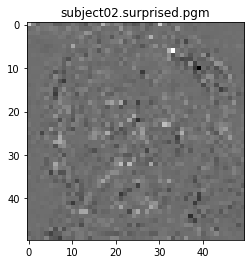

In [11]:
target_idx = np.random.choice(data.shape[0], 10)
target_data = data[target_idx]
target_filename = filename[target_idx]

print('Compute eigenfaces...')
W, mu = PCA(data, 25)
draw(target_data, target_filename, 'pca_eigenface', W, mu)

print('Compute fisherfaces...')
W = LDA(data, label, 25)
draw(target_data, target_filename, 'lda_fisherface', W)

# Part 2

In [12]:
W, mu = PCA(data, 25)
X_proj = (X - mu) @ W
test_proj = (test - mu) @ W
faceRecognition(X_proj, X_label, test_proj, test_label, 'PCA')

W = LDA(data, label, 25)
X_proj = X @ W
test_proj = test @ W
faceRecognition(X_proj, X_label, test_proj, test_label, 'LDA')

(2500,)
(2500, 2500)
(2500, 2500)
Face recognition with PCA and KNN:
K= 1, accuracy: 0.833 (25/30)
K= 3, accuracy: 0.833 (25/30)
K= 5, accuracy: 0.833 (25/30)
K= 7, accuracy: 0.800 (24/30)
K= 9, accuracy: 0.767 (23/30)
K=11, accuracy: 0.767 (23/30)

(2500, 2500)
[[ 2.80902423e-03 -2.90098503e-02 -2.90098503e-02 ...  3.69740517e-02
   3.69740517e-02 -3.52768919e-02]
 [ 1.07435139e-03  1.16774855e-02  1.16774855e-02 ... -2.23657294e-03
  -2.23657294e-03  3.32145606e-02]
 [ 4.69475490e-03  1.04981807e-03  1.04981807e-03 ... -1.07331571e-02
  -1.07331571e-02  6.76863032e-03]
 ...
 [ 4.50899089e-03 -1.00028714e-03 -1.00028714e-03 ... -5.25133783e-04
  -5.25133783e-04 -1.64608573e-04]
 [ 1.82499208e-03 -1.55175250e-03 -1.55175250e-03 ...  1.13485426e-03
   1.13485426e-03 -1.37859816e-03]
 [ 2.49908085e-04  3.18572816e-04  3.18572816e-04 ...  2.05991184e-05
   2.05991184e-05  4.41687460e-04]]
Face recognition with LDA and KNN:
K= 1, accuracy: 0.900 (27/30)
K= 3, accuracy: 0.767 (23/30)
K= 5, 

# Part 3

In [9]:
kernel_type = 3
            
new_coor = kernelPCA(data, 25, kernel_type)
new_X = new_coor[:X.shape[0], :]
new_test = new_coor[X.shape[0]:, :]
faceRecognition(new_X, X_label, new_test, test_label, 'PCA', kernel_type)

new_coor = kernelLDA(data, label, 25, kernel_type)
new_X = new_coor[:X.shape[0]]
new_test = new_coor[X.shape[0]:]
faceRecognition(new_X, X_label, new_test, test_label, 'LDA', kernel_type)

Face recognition with Kernel PCA(rbf kernel) and KNN:
K= 1, accuracy: 0.833 (25/30)
K= 3, accuracy: 0.833 (25/30)
K= 5, accuracy: 0.800 (24/30)
K= 7, accuracy: 0.767 (23/30)
K= 9, accuracy: 0.833 (25/30)
K=11, accuracy: 0.800 (24/30)

Face recognition with Kernel LDA(rbf kernel) and KNN:
K= 1, accuracy: 0.733 (22/30)
K= 3, accuracy: 0.767 (23/30)
K= 5, accuracy: 0.733 (22/30)
K= 7, accuracy: 0.700 (21/30)
K= 9, accuracy: 0.667 (20/30)
K=11, accuracy: 0.700 (21/30)

